In [63]:
%pylab notebook
import sys, os
sys.path.append(os.path.abspath('../../'))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "jet"
import healpy as h
from modules import binned_master
from flat_sky_codes import flat_sky_analysis as fsa
from settings import global_mmf_settings as gset
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In [91]:
outpath="./"
gset.setup_mmf_config(outpath=outpath,xsize=10.)
def return_edge_apodized_mask(edge_width=17.,fwhm=20.):
	mask=np.ones((gset.mmfset.npix,gset.mmfset.npix),float)
	epix=np.int(np.ceil(edge_width/gset.mmfset.reso))
	mask[:epix,:]=0 ; mask[gset.mmfset.npix-epix:,:]=0
	mask[:,:epix]=0 ; mask[:,gset.mmfset.npix-epix:]=0
	ell,bl=fsa.get_gauss_beam(fwhm,20000)
	mask=fsa.filter_map(mask,gset.mmfset.reso,bl,ell)
	return mask

<IPython.core.display.Javascript object>


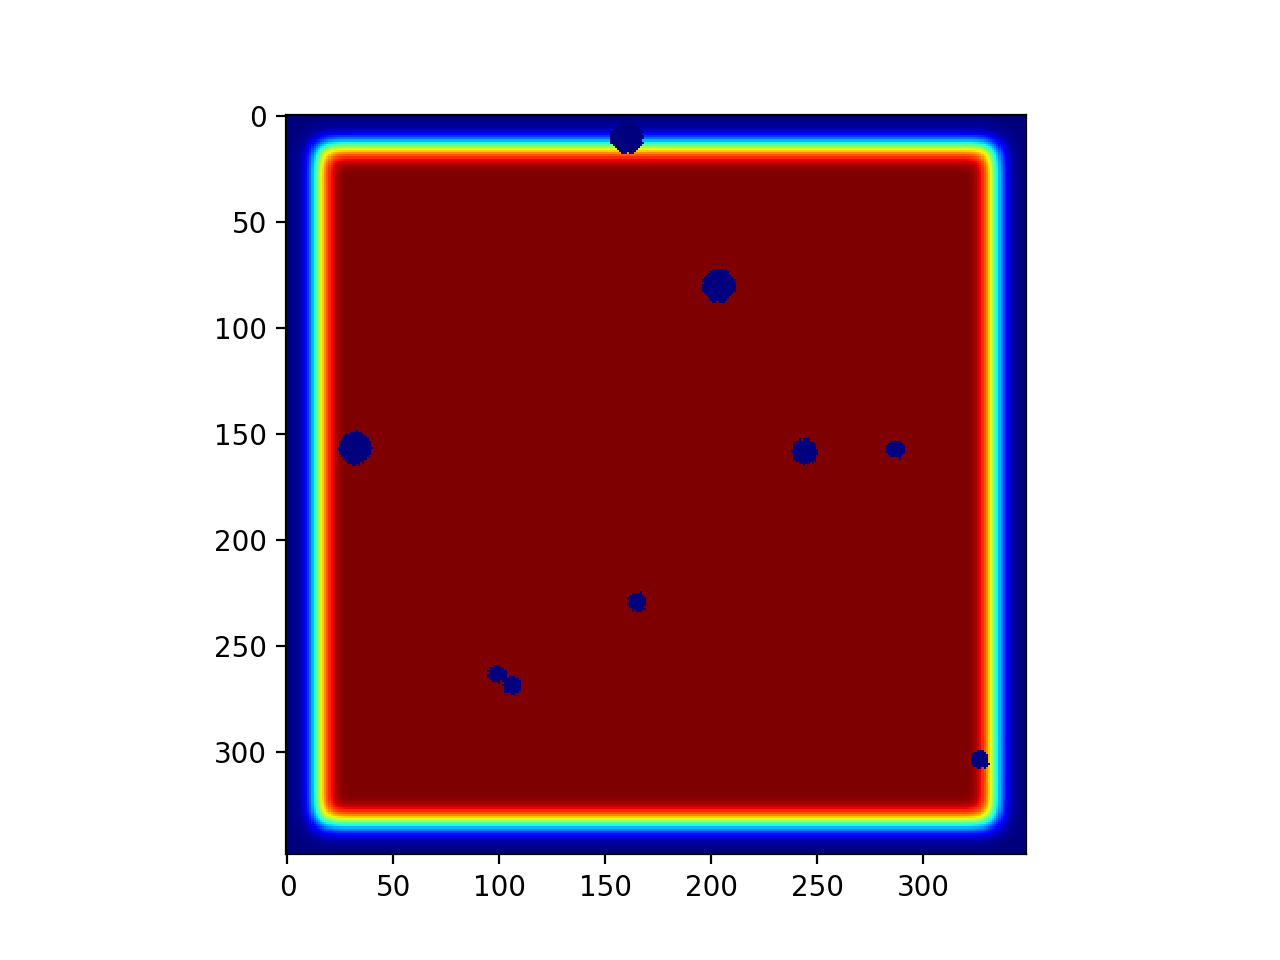

0.828412102185


In [93]:
mask=return_edge_apodized_mask(80.)
f1=fits.open("../../../../results/planck_pr1/planck_cosmo_cat/data/tangent_planes/10deg_patches/cluster_G111.01+31.76.fits")
mask=return_edge_apodized_mask(edge_width=25.)*f1[3].data
figure()
imshow(mask)
fsky=sum(mask)/size(mask) ; print fsky



<IPython.core.display.Javascript object>


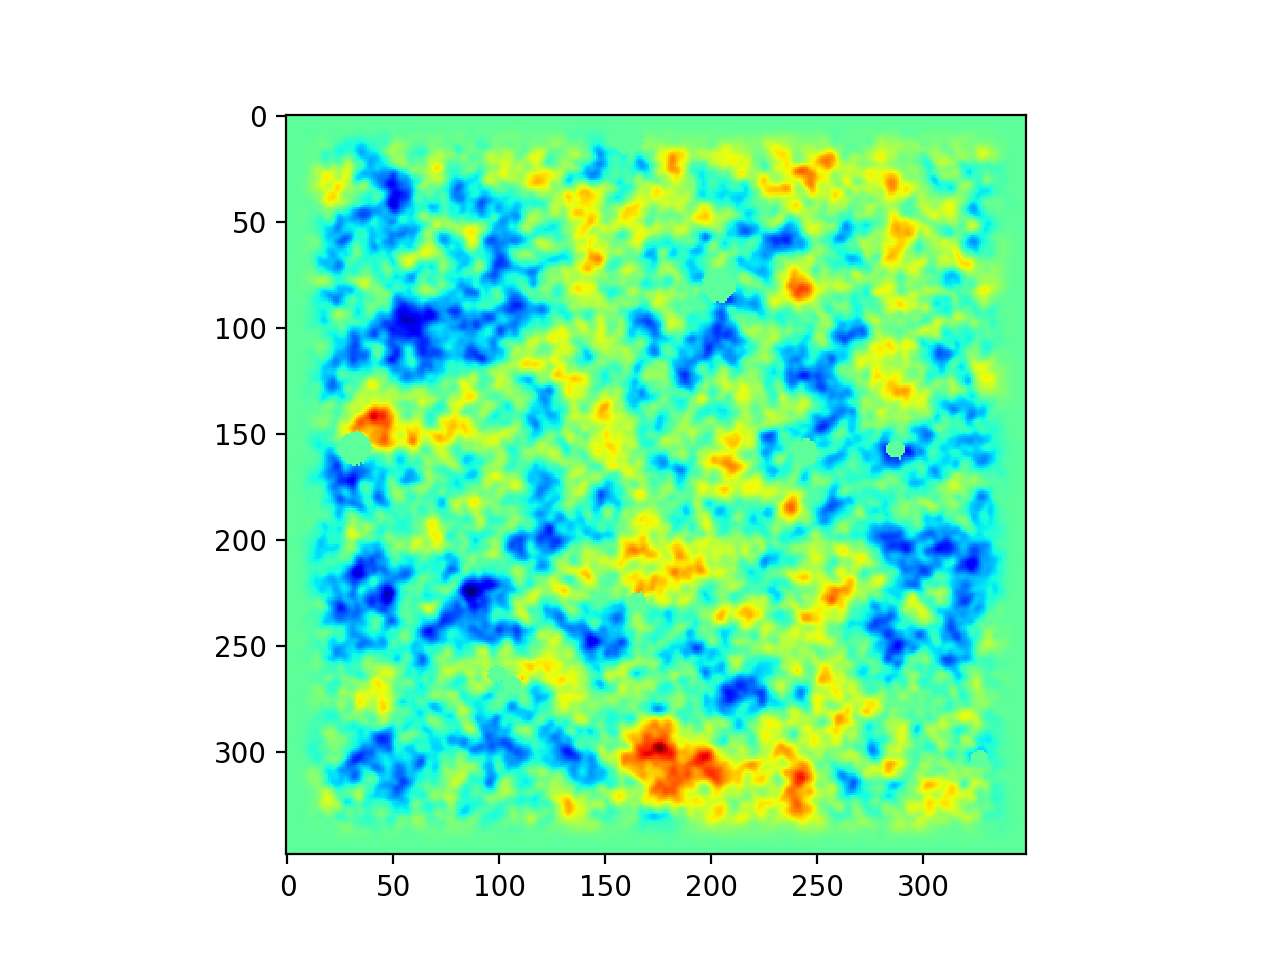

In [94]:
cl=h.read_cl("/Users/adityarotti/Documents/Work/Data/Planck/spectra/planck_wp_highL_lensing_param.fits")[0]
ell=arange(np.size(cl))
# figure()
# plot(ell,ell*(ell+1)*cl/(2.*pi))

sim=fsa.gensim(cl,gset.mmfset.npix,gset.mmfset.reso,ell=ell)
figure()
imshow(sim*mask)

<IPython.core.display.Javascript object>


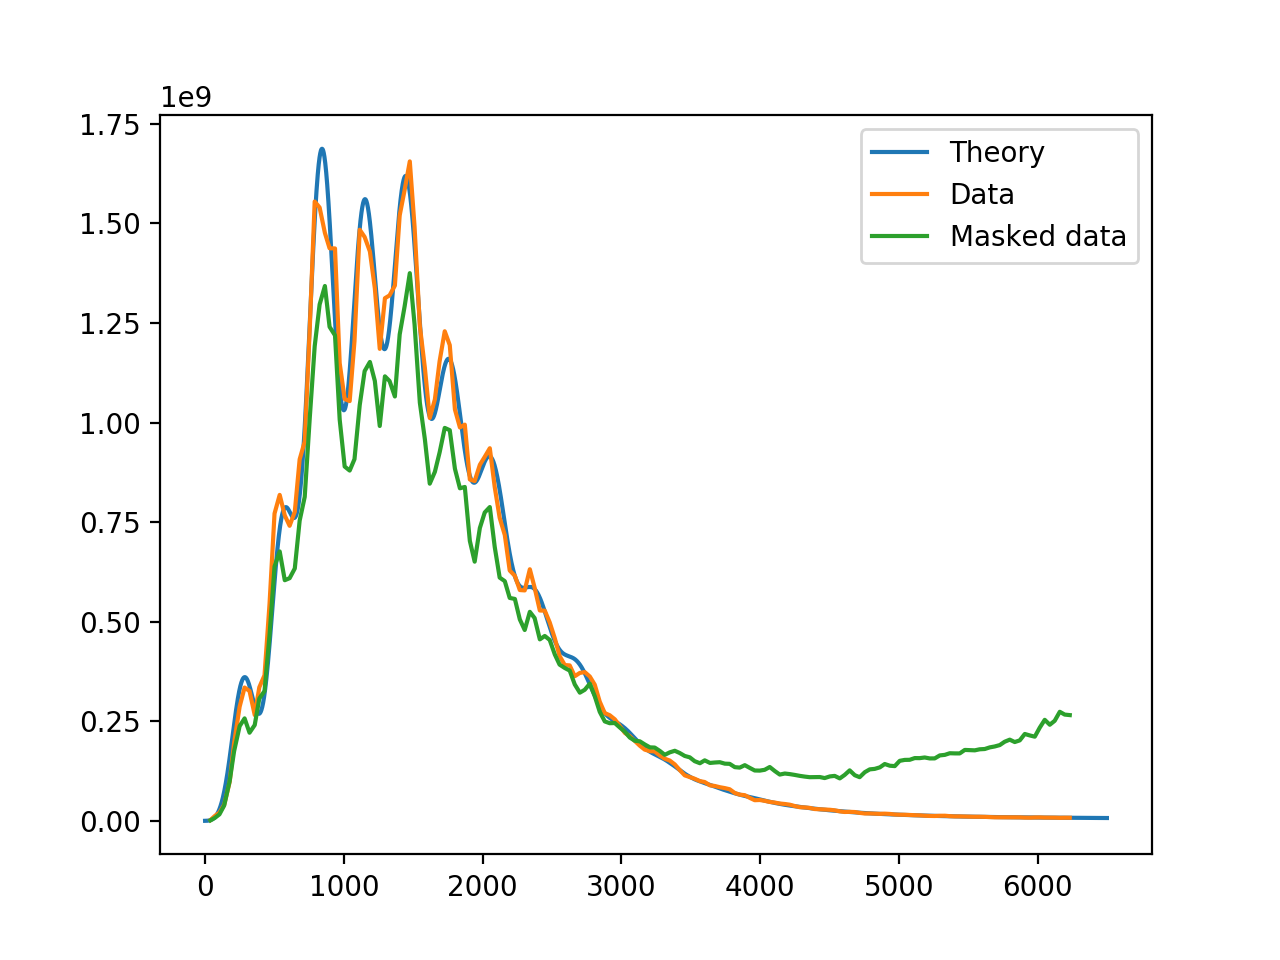

<IPython.core.display.Javascript object>


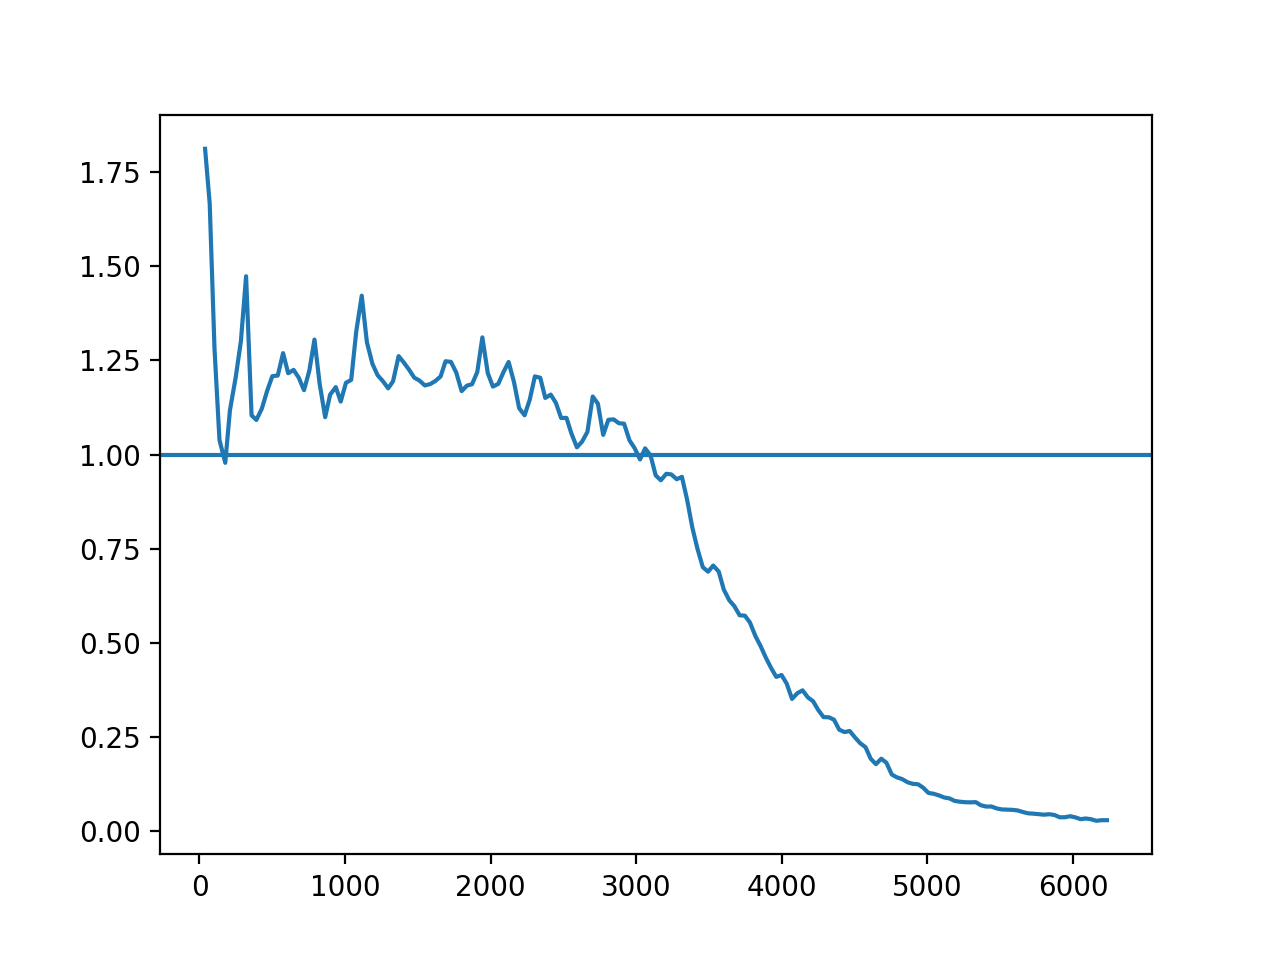

In [95]:
elld,clmask=fsa.map2cl(mask,gset.mmfset.reso,smwin=2)
elld,clwm=fsa.map2cl(sim*mask,gset.mmfset.reso,smwin=2)
elld,cld=fsa.map2cl(sim,gset.mmfset.reso,smwin=2)
figure()
plot(ell,(ell**4)*cl/(2.*pi),label="Theory")
plot(elld,(elld**4)*cld/(2.*pi),label="Data")
plot(elld,(elld**4.)*clwm/(2.*pi),label="Masked data")
legend(loc=0)
#semilogy()
#ylim(1e-1,6e3)

figure()
plot(elld,cld/clwm)
axhline(1.)

In [96]:
def J(k1,k2,k3):
    temp=(2./np.pi)/np.sqrt(2.*((k1*k2)**2. + (k1*k3)**2. + (k2*k3)**2.) - k1**4. - k2**4. -k3**4.)
    return temp

k=elld
dk=mean(k[1:]-k[:-1])
W=np.zeros((np.size(elld),np.size(elld)),float)
for ik1,k1 in enumerate(k):
    for ik2,k2 in enumerate(k[k>=k1]):
        ik3=np.where((k>=abs(k1-k2)) & (k<=(k1+k2)) )[0]
        k3=k[ik3]
        if np.size(k3)>0:
            W[ik1,ik2+ik1]=np.sum(clmask[ik3]*J(k1,k2,k3)*k3*dk)*2.*pi
            W[ik2+ik1,ik1]=(W[ik1,ik2+ik1])
            W[ik1,ik2+ik1]=W[ik1,ik2+ik1]*k2*dk

<IPython.core.display.Javascript object>


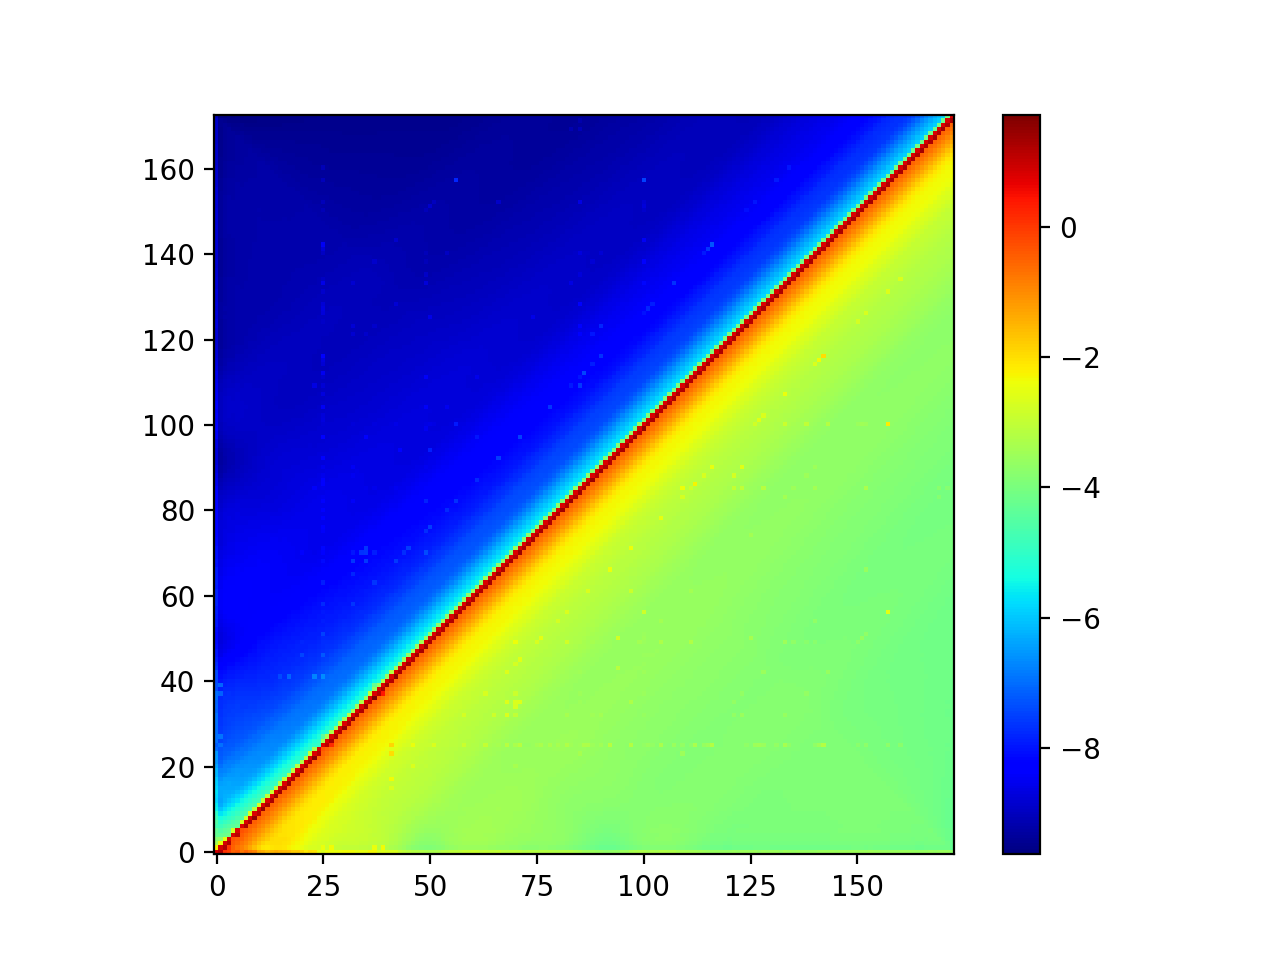

In [97]:
figure()
imshow(log10(W),origin="lower")
colorbar()

In [98]:
tcl=np.array(np.matmul(W,np.transpose(np.matrix(cld))).flatten()[0])[0]

In [99]:
winv=np.linalg.pinv(W,rcond=1e-6)

<IPython.core.display.Javascript object>


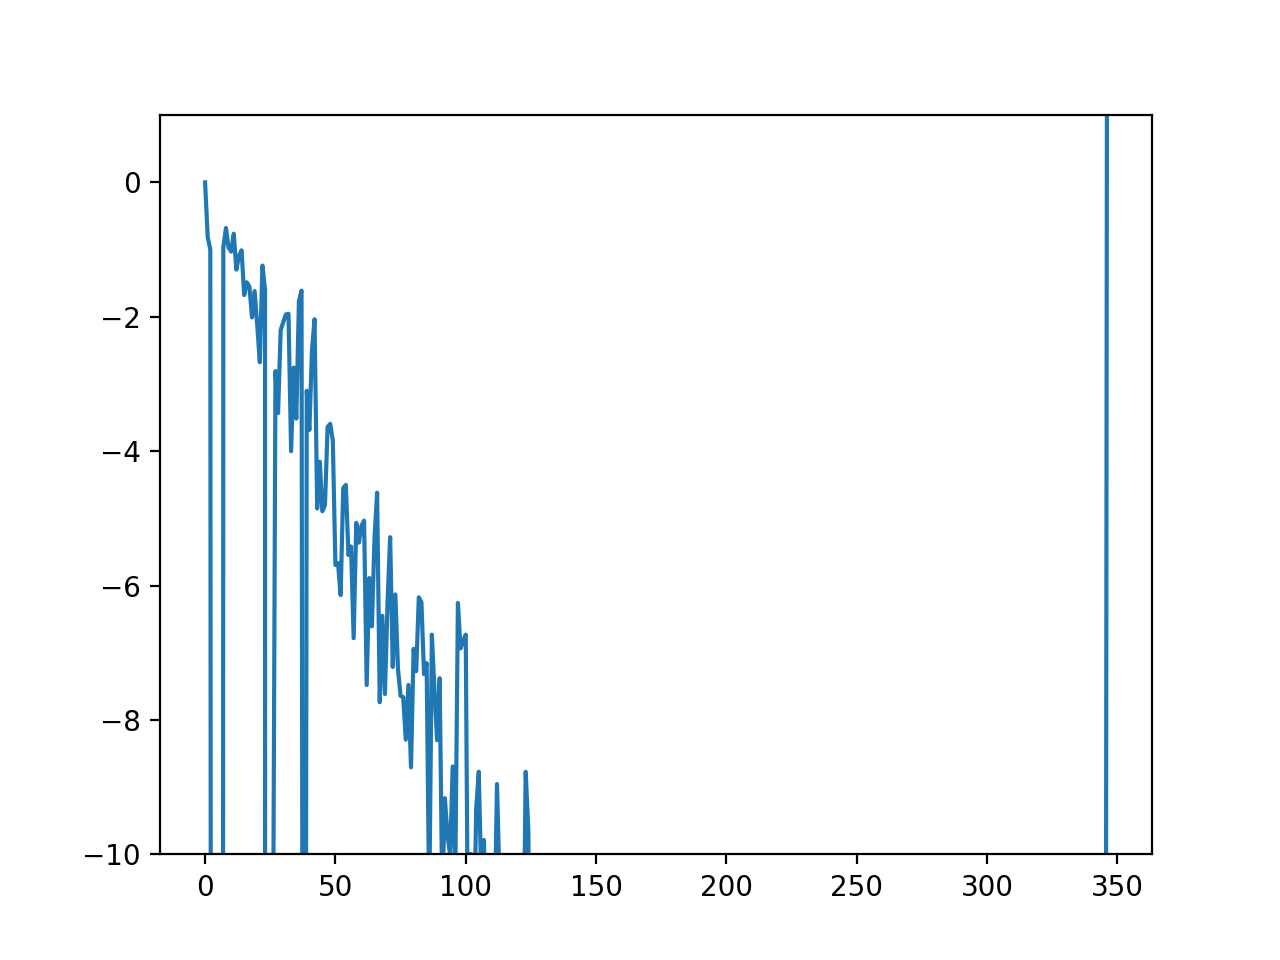

(-10, 1)

In [56]:
figure()
plot(diag(winv))
ylim(-10,1)

In [57]:
tcl=np.array(np.matmul(np.transpose(np.matrix(winv)),np.transpose(np.matrix(clwm))).flatten()[0])[0]

<IPython.core.display.Javascript object>


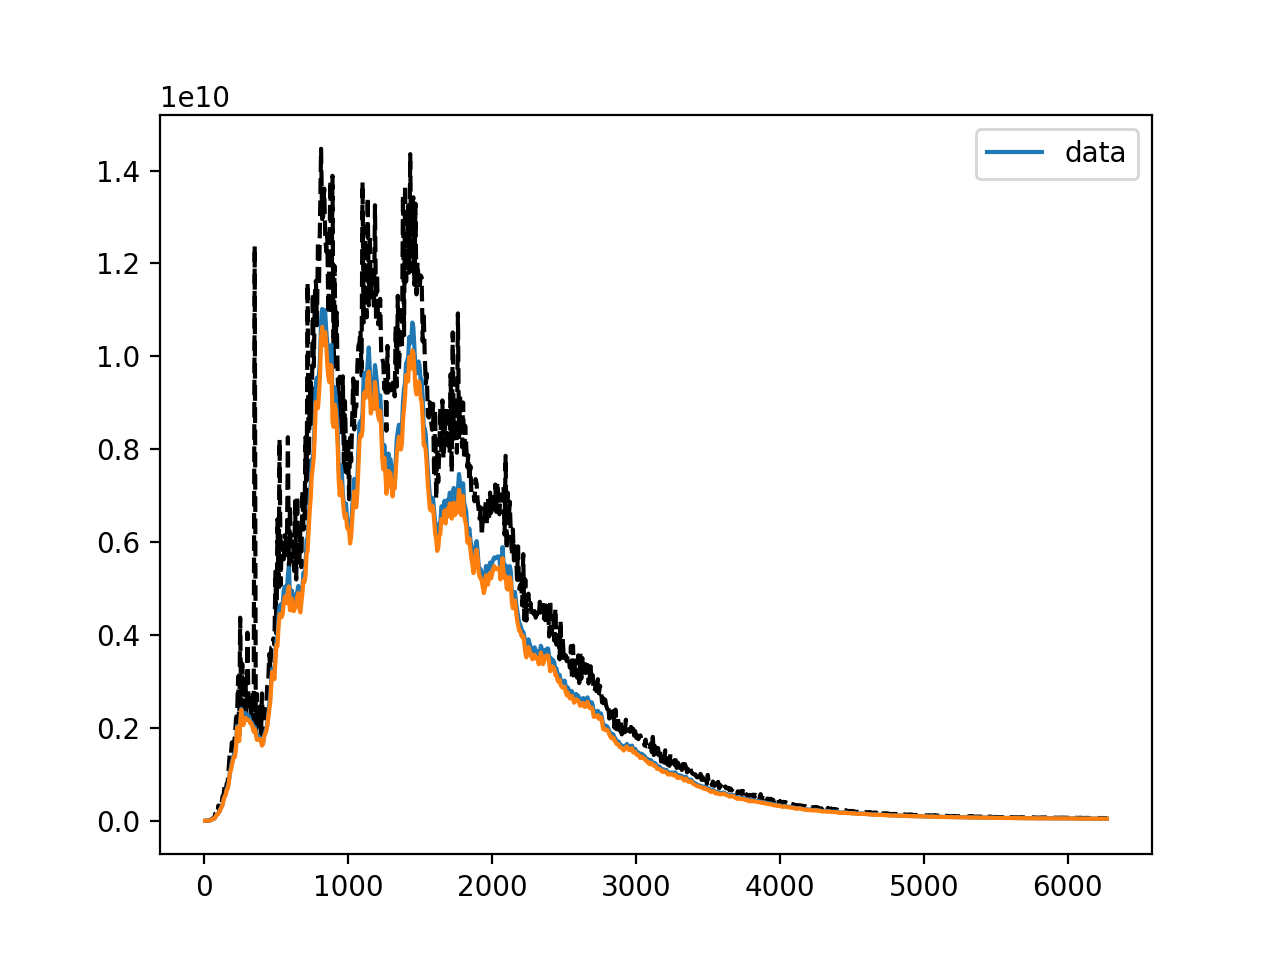

In [84]:
figure()
plot(elld,(elld**4.)*tcl/2/pi/4,"k--")
plot(elld,(elld**4.)*cld,label="data")
plot(elld,(elld**4.)*clwm)
legend(loc=0)
#loglog()

In [87]:
((gset.mmfset.reso/60.)*np.pi/180.)**2.*gset.mmfset.npix**2.

0.76112711190787496

<IPython.core.display.Javascript object>


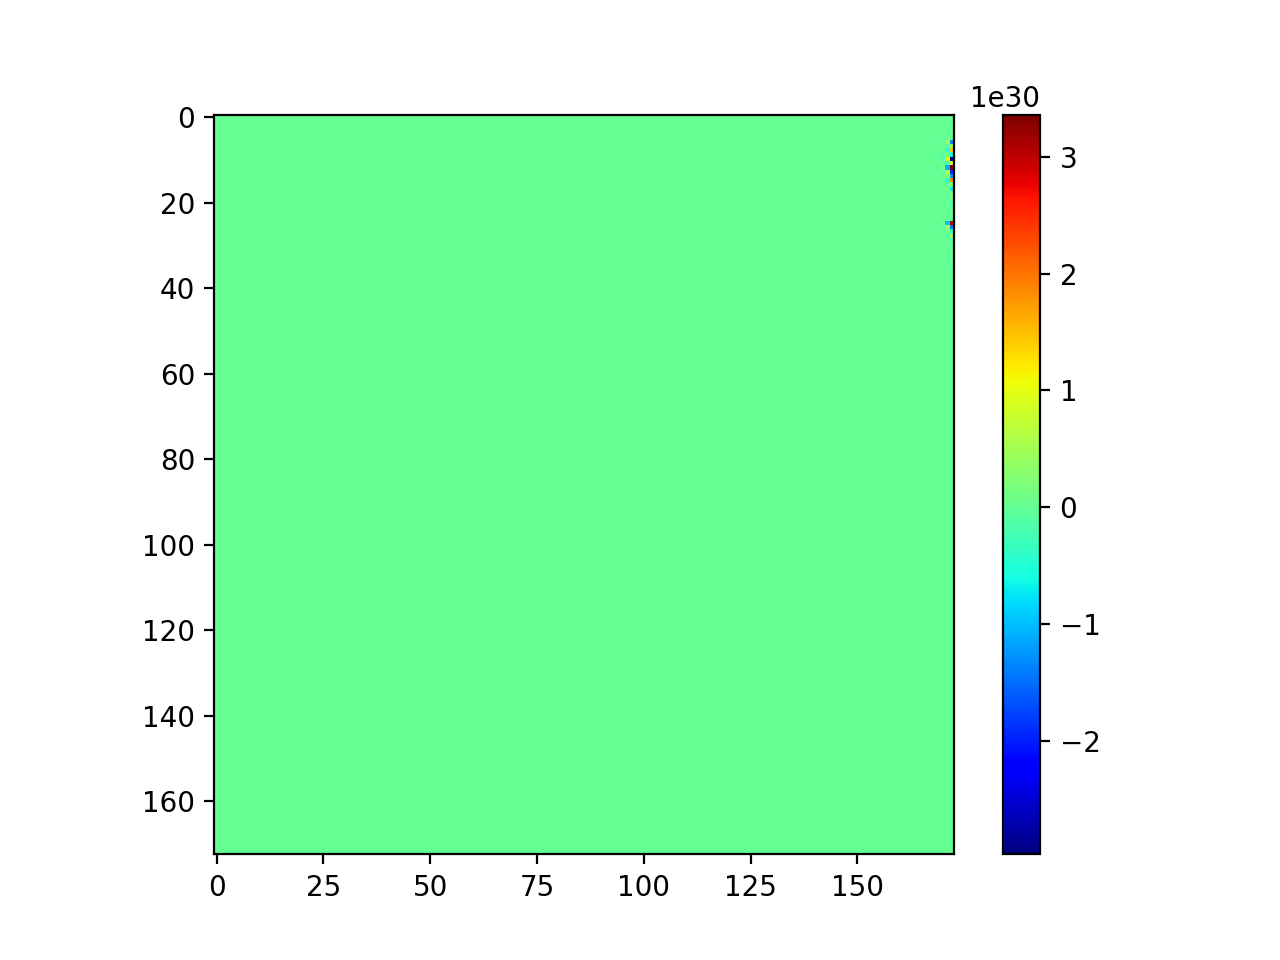

In [21]:
figure()
imshow(winv)
colorbar()

# Simulated coupling matrix

In [100]:
from scipy.interpolate import interp1d
fn_cl=interp1d(ell,cl)
clthry=fn_cl(elld)

W=np.zeros((np.size(elld[1:]),np.size(elld[1:])),float)
nrlz=200
for i in range(nrlz):
    sim=fsa.gensim(cl,gset.mmfset.npix,gset.mmfset.reso,ell=ell)
    elld,cld=fsa.map2cl(sim,gset.mmfset.reso)
    cld=cld-clthry[1:]
    W=W+np.matmul(np.transpose(np.matrix(cld[1:])),np.matrix(cld[1:]))

ValueError: operands could not be broadcast together with shapes (174,) (172,) 

In [174]:
norm=np.matmul(np.transpose(np.matrix(clthry[1:])),np.matrix(clthry[1:]))*nrlz

<IPython.core.display.Javascript object>


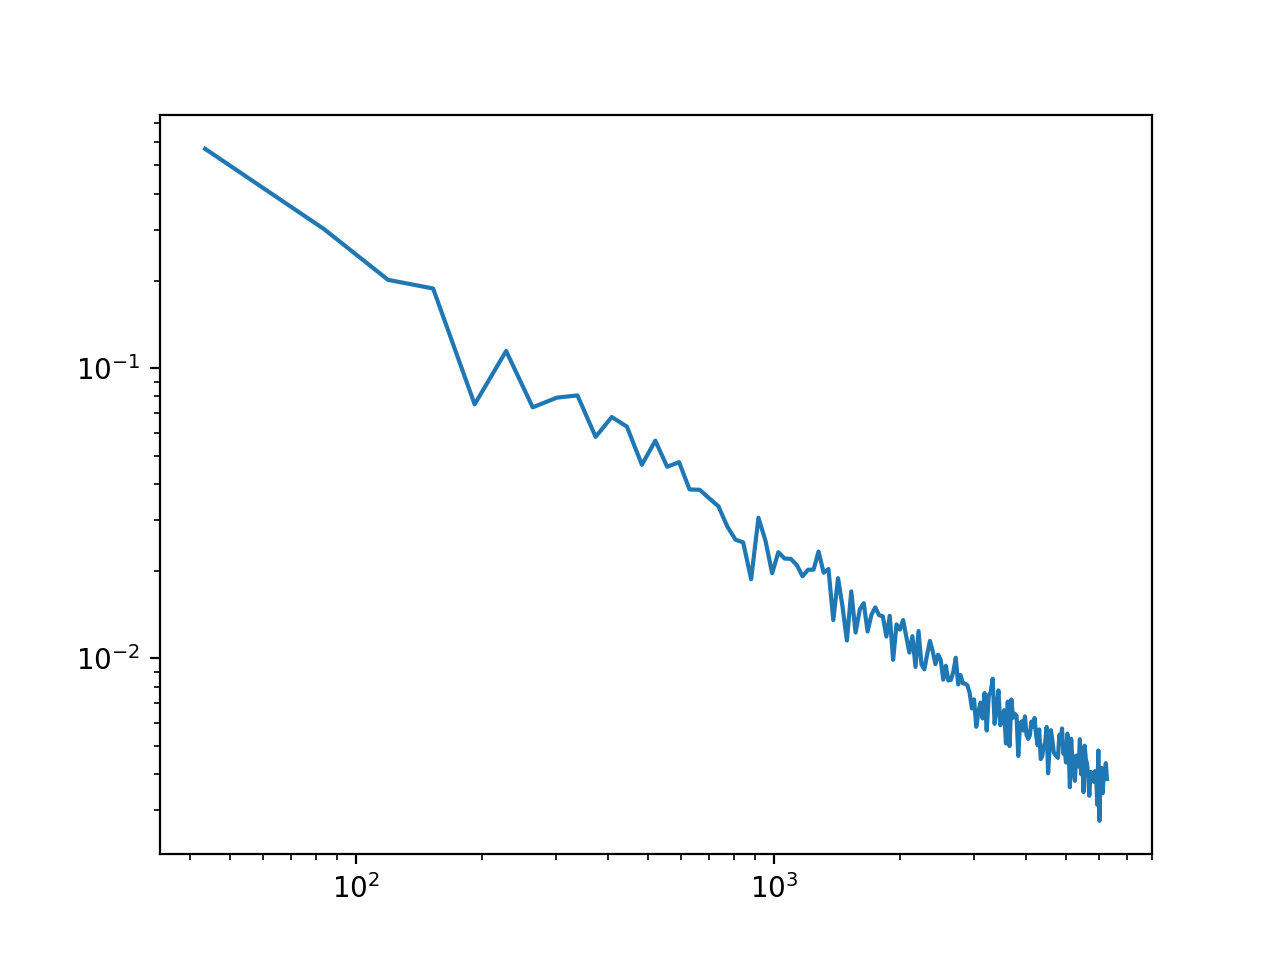

[]

In [183]:
figure()
plot(elld[1:],diag(W/norm))
loglog()

<IPython.core.display.Javascript object>


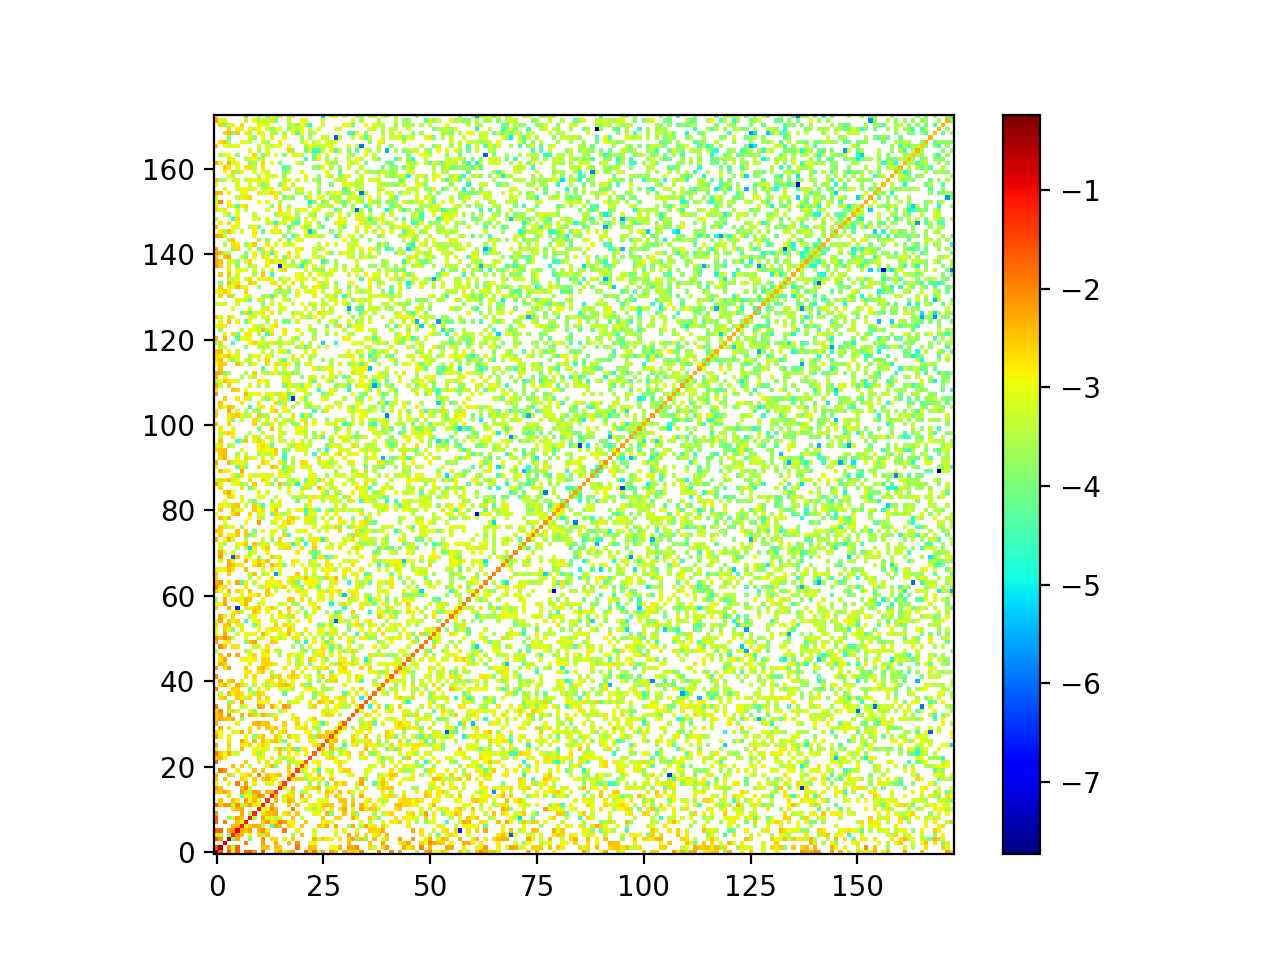

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [179]:
figure()
imshow(log10(W/norm),origin="lower")
colorbar()